# ECE-6524 / CS-6524 Deep Learning
# Assignment 1 [90 pts]

In this assignment, **you need to complete the following three sectoins**:
1. SVM Classifier
    - Calculating loss and gradient
2. Linear Classfier with Softmax 
    - Calculating loss and gradient
3. Simple Neural Network with Multilayer Perceptrons
    - Read the forward and backward propogation
    - Experiment with simple NN

This assignment is inspired and adopted from Stanford CS231n, UIUC Deep Learning course and Deep Learning Lab from Professor Vicente Ordonez at the University of Virginia.
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. 
7. Zip BOTH the PDF file and this notebook. Rem
8. Submit your zipped file.

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: juvekaradheesh
### Reference (if any):

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. numupy
2. matplotlib
3. scipy
```
All packages above can be installed through `pip install`.

In addition, you will need to have [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in your `cifar10/cifar-10-batches-py` folder. We provide a bash script `cifar10/get_dataset.sh` to help you download and unpack the dataset.

Once you are done with the things above, you can proceed to execute the following cells:

In [1]:
import random
import numpy as np
from data_process import get_CIFAR10_data
import math
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Loading CIFAR-10

In the following cells, we would first load the CIFAR10 dataset, and prepare them for our classifier:

In [2]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 1000

In [3]:
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES, subtract_mean=False)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(49000, 32, 32, 3)
(49000,)
(1000, 32, 32, 3)
(1000,)
(1000, 32, 32, 3)
(1000,)


Now, we visualize the dataset to get a better idea of it.

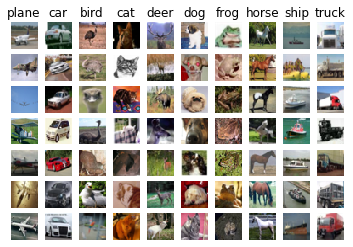

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

We then subtract all the images with the **mean image** of the training set. This trick is commonly used in Computer Vision community, as it arranges the features into a range that is more manageable for the models.

In [6]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

Now, we convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector. This allows us to feed the data into our classifiers.

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3072)
(1000, 3072)
(1000, 3072)


Here, we concatenate all the features with ones. This trick is particularly convenient, as in this case, we only need to deal with a single weight matrix $W$ instead of both $W$ and bias $b$ in our training code.

In [9]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [10]:
# you should get the following output:
# (49000, 3073)
# (1000, 3073)
# (1000, 3073)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3073)
(1000, 3073)
(1000, 3073)


### Calculate Classification Accuracy

Here is a simple helper function for calculation the classification accuracy:

In [11]:
def get_acc(pred, y_test):
    return np.sum(y_test==pred)/len(y_test)*100

In [12]:
# test get_acc
print(get_acc(y_train, y_train))

100.0


# Section 1. Support Vector Machines (with SGD) [30 pts]

In this section, you will need to implement a **soft margin SVM** for a **multi-class classification problem**. In the soft margin SVM, you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

## 1.1. Implementing SVM with SGD [25 pts]

Recall that the multiclass SVM loss can be written as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = \sum_{j\neq y_i} \left[ \max(0, s_j - s_{y_i} + margin) \right]
\end{gathered}
\end{align}
where $s={s_j}$ is the vector of prediction scores of all class, $s_j$ is the prediction score for class $j$, and $y_i$ is the groud truth class label. The margin is usually set to 1. Now, to learn the weights $W$, we can differentiate the function $L_i$ to get the gradient:
\begin{equation}
\begin{gathered}
\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) \right) x_i\\
\end{gathered}
\end{equation}
where $\mathbb{1}$ is the indicator function that is one if the condition inside is true or zero otherwise, and $w_j$ represents the row $j$ in your weight matrix $W$. To implement this, you’d simply count the number of classes that didn’t meet the desired margin 1 (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient. Note that, in the equation above, we are only calculating the gradient with respect to the row of $W$ that corresponds to the correct class $y_i$. For the other rows $j\neq y_i$, we have:
\begin{equation}
\nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) x_i
\end{equation}
Now, we have derived the gradient expression above, it is time to turn these equations into the actual running code.
We provide a template for implementing your SVM classfier below. You have to fill in the **TODO** part, and train your classifier.

In [13]:
 
class SVM():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
        
    def calc_grad_and_loss(self, X_train, y_train, reg, margin):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
        """
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        
        # Calculate score
        
        # s = W.x
        s = X_train.dot(self.w)
        
        # Calculate Loss
        
        # Encode y_train to one-hot matrix
        y_train_one_hot = np.zeros((y_train.size, y_train.max()+1))
        y_train_one_hot[np.arange(y_train.size),y_train] = 1
        y_train_one_hot = np.array(y_train_one_hot, dtype = bool)
        
        # Do max(0, s_j - s_(y_i) + margin), where j!=(y_i)
        s_yi = s[y_train_one_hot]
        s_yi_tiled = np.tile(s_yi, (s.shape[1],1)).transpose()
        sub = np.where(y_train_one_hot,0, s-s_yi_tiled+margin)
        max_ = np.maximum(np.zeros(s.shape), sub)
        
        # Calculate loss over the batch with L2 regularization
        loss = np.mean(np.sum(max_,axis=1)) + (reg)*np.sum(self.w**2)
        
        
        # Calculate Gradient
        indicator = sub > 0
        count = np.sum(indicator, axis=1)
        indicator = indicator+0
        indicator[np.arange(X_train.shape[0]), y_train] = -count
        d_loss = X_train.T.dot(indicator)
        d_loss = d_loss
        d_loss = d_loss/X_train.shape[0]
        grad_w = d_loss + (2* reg* self.w)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
              n_iters=1500, batch_size=200):
        """
        Train SVM classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - margin: A float number margin for the multi-class SVM loss (usually set to 1);
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const, margin)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        s = np.dot(X_test, self.w)
        pred = np.argmax(s, axis=1)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred
    


### Train your SVM
Now, train your SVM classifier. You should expect the loss decreases as the training goes on.

In [14]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500,)

Iter 100/1500 - loss: 135.49142975724877 
Iter 200/1500 - loss: 111.94739717769608 
Iter 300/1500 - loss: 89.48455607228655 
Iter 400/1500 - loss: 74.57877561659392 
Iter 500/1500 - loss: 61.894252436539084 
Iter 600/1500 - loss: 50.929617050989975 
Iter 700/1500 - loss: 42.084026306063826 
Iter 800/1500 - loss: 35.499919462451246 
Iter 900/1500 - loss: 29.94653477814258 
Iter 1000/1500 - loss: 24.928668368837812 
Iter 1100/1500 - loss: 21.44913510130548 
Iter 1200/1500 - loss: 18.713951963051088 
Iter 1300/1500 - loss: 15.964617808754035 
Iter 1400/1500 - loss: 13.667031901867915 
Iter 1500/1500 - loss: 11.895500354352365 


### Plot the Loss Curve
Plotting the loss curve is a proper etiquette for Machine Learning/Deep Learning practitioner.

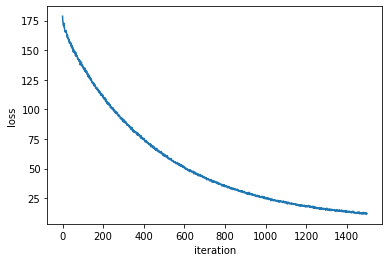

In [15]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the SVM is implemented correctly, you shuold get an training/validation accuracy around 34%-35%.

In [16]:
pred_svm = svm.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_svm, y_train)))
pred_svm = svm.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

The training accuracy is given by : 37.702041
The validation accuracy is given by : 36.000000


## Section 1.2. Improve your SVM [5 pts]
Now, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.**

### Let's perform Hyperparameter search to find optimal regularization constant
- old `reg_const` = 5000 (5e3)
- new `reg_const` =  [3e3, 5e3, 7e3]
- old `lr` = 5000 (5e3)
- new `lr` =  [1e-6, 1e-7]

In [17]:
reg_consts =  [3e3, 5e3, 7e3]
lrs = [1e-5, 1e-6, 1e-7]
n_iter = 1500

best_acc = 0

for reg_const in reg_consts:
    for lr in lrs:
        print('Current combinations: lr, n_iter, reg_const = %f %f %f' % (lr, n_iter, reg_const))
        svm = SVM(num_features, num_classes)
        loss_hist = svm.train(X_train, y_train, lr=lr, reg_const=reg_const, n_iters=n_iter)
        pred_svm = svm.predict(X_val)
        print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))
        curr_acc = get_acc(pred_svm, y_val)
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_lr = lr
            best_n_iter = n_iter
            best_reg_const = reg_const
            best_svm = svm

Current combinations: lr, n_iter, reg_const = 0.000010 1500.000000 3000.000000
Iter 100/1500 - loss: 20.607535369470114 
Iter 200/1500 - loss: 33.502275397795835 
Iter 300/1500 - loss: 47.05490494353833 
Iter 400/1500 - loss: 21.811402062882756 
Iter 500/1500 - loss: 20.04339491604854 
Iter 600/1500 - loss: 29.54577883110104 
Iter 700/1500 - loss: 34.088683402605554 
Iter 800/1500 - loss: 34.833616228324225 
Iter 900/1500 - loss: 28.125750189090656 
Iter 1000/1500 - loss: 40.71054776012918 
Iter 1100/1500 - loss: 31.01435427326196 
Iter 1200/1500 - loss: 23.30932624881885 
Iter 1300/1500 - loss: 26.30196235982971 
Iter 1400/1500 - loss: 23.21431636970606 
Iter 1500/1500 - loss: 19.512938480720585 
The validation accuracy is given by : 23.100000
Current combinations: lr, n_iter, reg_const = 0.000001 1500.000000 3000.000000
Iter 100/1500 - loss: 33.523071034526765 
Iter 200/1500 - loss: 13.262712738882415 
Iter 300/1500 - loss: 8.49159329866302 
Iter 400/1500 - loss: 7.731695364863206 
I

In [18]:
print('Best combinations: lr, n_iter, reg_const = %.8f %f %f' % (best_lr, best_n_iter, best_reg_const))
print(best_acc)

Best combinations: lr, n_iter, reg_const = 0.00000010 1500.000000 7000.000000
38.5


### Now let's train a model again newly found hyperparameters and plot the loss and also test on validation data and test data.

In [19]:
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=best_lr, reg_const=best_reg_const, n_iters=best_n_iter,)

Iter 100/1500 - loss: 173.66932426157516 
Iter 200/1500 - loss: 131.14829261834566 
Iter 300/1500 - loss: 100.68409166759966 
Iter 400/1500 - loss: 75.30300055227166 
Iter 500/1500 - loss: 58.39610960471069 
Iter 600/1500 - loss: 45.0451692182739 
Iter 700/1500 - loss: 35.13390137265077 
Iter 800/1500 - loss: 27.70180905657751 
Iter 900/1500 - loss: 21.82888318285228 
Iter 1000/1500 - loss: 17.28826530474325 
Iter 1100/1500 - loss: 14.714413872564036 
Iter 1200/1500 - loss: 11.74074828236366 
Iter 1300/1500 - loss: 10.11769502919726 
Iter 1400/1500 - loss: 9.16978778550521 
Iter 1500/1500 - loss: 8.076658921545686 


### Plot the Curve

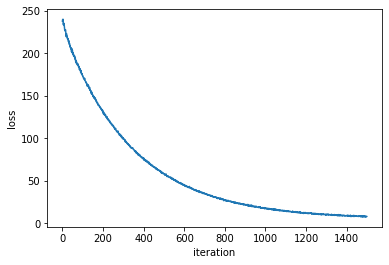

In [20]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy

In [21]:
pred_svm = svm.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_svm, y_train)))
pred_svm = svm.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

The training accuracy is given by : 38.126531
The validation accuracy is given by : 38.800000


### Test SVM
Evaluate the testing accuracy of your SVM:

In [22]:
pred_svm = svm.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_svm, y_test)))

The testing accuracy is given by : 38.200000


### Visualization
Visualize the weights of your best model. 

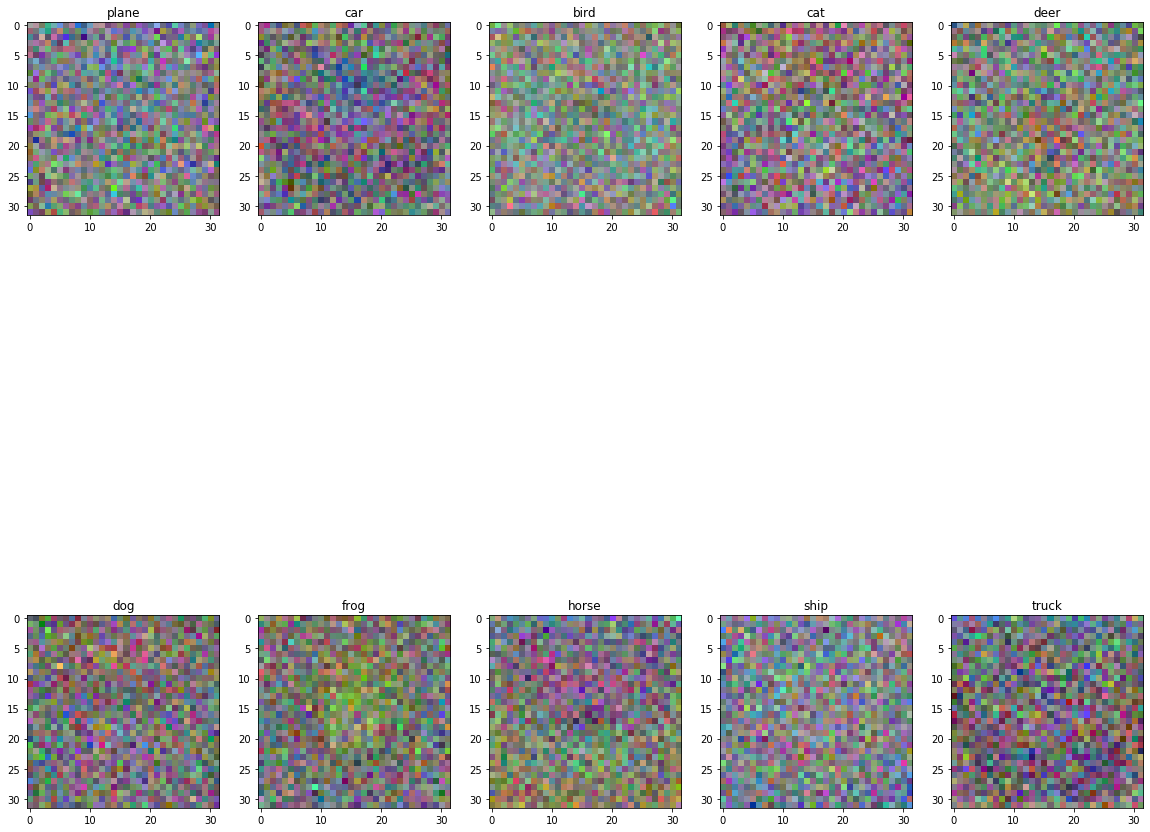

In [23]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (no bias) to (32, 32, 3, 10), and then rescale them back to 0-255 using min-max normalization.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

from sklearn.preprocessing import minmax_scale

# Process weights
temp = svm.w[:-1]
temp = minmax_scale(temp)
temp = temp.reshape((32,32,3,10))
temp *= 255
temp = temp.astype(int)


fig = plt.figure(figsize=(20,20))    

# Plot for each class
for i,c in enumerate(classes):
    ax = fig.add_subplot(2,5,i+1)
    imgplot = plt.imshow(temp[:,:,:,i])
    ax.set_title(c)

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

Your comments: We can see very blur images of car, horse, ship, truck being projected as class weights. The reason for the weights being too far away from the input image classes could be because of the margin that is used in SVM. The margin could be pushing the weights further away to separate the classes.

# Section 2. Softmax Classifier (with SGD) [30 pts]

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. 

## Section 2.1. Implement the Softmax Classifier [25 pts]
Recall that, from the lecture, we can write down the loss function as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = -\log\left({\frac{e^{s_{y_i}}} {\sum_j e^{s_j}} }\right)
\end{gathered}
\end{align}

And, through some calculations, we can obtain the expression for the gradient:
\begin{align}
\nabla_{w_{l}} L_i = \left(\frac{e^{w_l^Tx_i}} {\sum_j e^{w_j^Tx_i}} - \mathbb{1}\left(y_i=l\right)\right) x_i\\
\end{align}


The softmax classifier also has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

Same as the previous section, we provide a template for you to implement your classifier:

In [24]:
class Softmax_Classfier():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
    
    def softmax(self, logits):
        ################################################################################
        # TODO:                                                                        #
        # Implement the softmax function here.                                         #
        ################################################################################
        num = np.exp(logits)
        den = np.sum(num, axis = 1,  keepdims=True)
        probs = num / den
        assert np.isclose(1,(np.sum(probs, axis=1))).all()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return probs
    
    def calc_grad_and_loss(self, X_train, y_train, reg_const):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
         """ 
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        
        # Calculate score
        
        # s = W.x
        s = X_train.dot(self.w)
        
        # Calculate Loss with L2 Regularization
        softmax = self.softmax(s)
        loss_each = - np.log(softmax[np.arange(len(softmax)), y_train])
        loss = np.mean(loss_each) + (reg_const)*np.sum(self.w**2)
        
        # Calculate Gradient
        softmax[np.arange(len(softmax)), y_train] -= 1
        d_loss = X_train.T.dot(softmax)
        d_loss = d_loss/X_train.shape[0]
        grad_w = d_loss + (2* reg_const* self.w)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, 
              n_iters=1500, batch_size=200):
        """
        Train softmax classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        s = np.dot(X_test, self.w)
        pred = np.argmax(s, axis=1)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred


In [25]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
softmax_classifier = Softmax_Classfier(num_features, num_classes)
loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=2e3, n_iters=1500, batch_size=batch_size)


Iter 100/1500 - loss: 60.51476895084055 
Iter 200/1500 - loss: 55.48489196074227 
Iter 300/1500 - loss: 50.93912880450204 
Iter 400/1500 - loss: 47.17111339889468 
Iter 500/1500 - loss: 43.38777725897858 
Iter 600/1500 - loss: 40.429980717205694 
Iter 700/1500 - loss: 37.29581767475489 
Iter 800/1500 - loss: 34.58140380559525 
Iter 900/1500 - loss: 31.81072780457151 
Iter 1000/1500 - loss: 29.57572702365183 
Iter 1100/1500 - loss: 27.385233880231315 
Iter 1200/1500 - loss: 25.347690766890544 
Iter 1300/1500 - loss: 23.424072537738382 
Iter 1400/1500 - loss: 21.98730259794672 
Iter 1500/1500 - loss: 20.34289027143181 


Again, plot the loss:

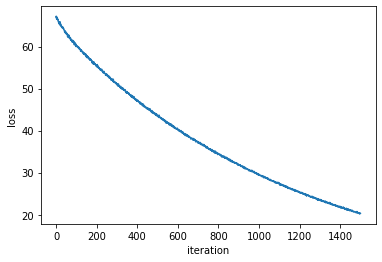

In [26]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the Softmax Classifier is implemented correctly, you shuold get an accuracy around 29%.

In [27]:
pred_softmax = softmax_classifier.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
pred_softmax = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

The training accuracy is given by : 28.055102
The validation accuracy is given by : 29.000000


## Section 2.1. Improve your Softmax Classifier [5 pts]
Again, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.** In addition, <span style="color:red">**We expect to see an accuracy around 34% after the improvement.**</span>


### Let's perform Grid search to find optimal hyperparameters
- old `lr` = 0.0000001 (1e-7)
- new `lr` =  [1e-6, 1e-7, 1e-8]
- old `reg_const` = 5000 (5e3)
- new `reg_const` =  [1e3, 3e3, 5e3, 7e3]

In [28]:
# Get the accuracy to above 34%! 
# For hyperparameter search, you can try different combinations of (reg_const, margin, lr)

reg_consts =  [1e3, 3e3, 5e3, 7e3]
lrs = [1e-6, 1e-7, 1e-8]
n_iter = 1500

best_acc = 0

for reg_const in reg_consts:
    for lr in lrs:
        kf_acc = []
        print('Current combinations: lr, n_iter, reg_const = %f %f %f' % (lr, n_iter, reg_const))
        sotftmax_classifier = Softmax_Classfier(num_features, num_classes)
        loss_hist = sotftmax_classifier.train(X_train, y_train, lr=lr, reg_const=reg_const, n_iters=n_iter)
        pred_softmax = sotftmax_classifier.predict(X_train)
        print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
        pred_softmax = svm.predict(X_val)
        print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))
        curr_acc = get_acc(pred_softmax, y_val)
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_lr = lr
            best_n_iter = n_iter
            best_reg_const = reg_const
            best_classifier = softmax_classifier
        print('The cross-validation accuracy is given by : %f' % (curr_acc))

# Save the best model to variable svm            
softmax_classifier = best_classifier

Current combinations: lr, n_iter, reg_const = 0.000001 1500.000000 1000.000000
Iter 100/1500 - loss: 22.854430385174997 
Iter 200/1500 - loss: 15.458472204113232 
Iter 300/1500 - loss: 10.871392465714266 
Iter 400/1500 - loss: 7.842014600901853 
Iter 500/1500 - loss: 5.873709254993599 
Iter 600/1500 - loss: 4.5069278761495575 
Iter 700/1500 - loss: 3.674436565108442 
Iter 800/1500 - loss: 2.9954436759008836 
Iter 900/1500 - loss: 2.7127146058654557 
Iter 1000/1500 - loss: 2.465775965845772 
Iter 1100/1500 - loss: 2.1538785610828803 
Iter 1200/1500 - loss: 2.0071818148439537 
Iter 1300/1500 - loss: 2.0456363889065603 
Iter 1400/1500 - loss: 2.0079757919173074 
Iter 1500/1500 - loss: 1.8394692758683284 
The training accuracy is given by : 40.330612
The validation accuracy is given by : 38.800000
The cross-validation accuracy is given by : 38.800000
Current combinations: lr, n_iter, reg_const = 0.000000 1500.000000 1000.000000
Iter 100/1500 - loss: 33.552567108727146 
Iter 200/1500 - loss

Iter 1100/1500 - loss: 1.989664243296033 
Iter 1200/1500 - loss: 2.0560113853150543 
Iter 1300/1500 - loss: 1.9776900367924943 
Iter 1400/1500 - loss: 2.0712468808599804 
Iter 1500/1500 - loss: 2.002929498674995 
The training accuracy is given by : 35.614286
The validation accuracy is given by : 38.800000
The cross-validation accuracy is given by : 38.800000
Current combinations: lr, n_iter, reg_const = 0.000000 1500.000000 7000.000000
Iter 100/1500 - loss: 166.2150028488254 
Iter 200/1500 - loss: 125.71358226756553 
Iter 300/1500 - loss: 95.2393728569308 
Iter 400/1500 - loss: 72.19666491287985 
Iter 500/1500 - loss: 54.851503603182735 
Iter 600/1500 - loss: 41.85147159598257 
Iter 700/1500 - loss: 32.01466059446048 
Iter 800/1500 - loss: 24.656806092170942 
Iter 900/1500 - loss: 19.232543469661746 
Iter 1000/1500 - loss: 14.91247254277733 
Iter 1100/1500 - loss: 11.663615521002322 
Iter 1200/1500 - loss: 9.379629413317907 
Iter 1300/1500 - loss: 7.424534131468973 
Iter 1400/1500 - lo

In [29]:
print('Best combinations: lr, n_iter, reg_const = %f %f %f' % (best_lr, best_n_iter, best_reg_const))
print(best_acc)

Best combinations: lr, n_iter, reg_const = 0.000001 1500.000000 1000.000000
38.800000000000004


### Now let's train a model again newly found hyperparameters and plot the loss and also test on validation data and test data.

In [30]:
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
softmax_classifer = Softmax_Classfier(num_features, num_classes)
loss_hist = softmax_classifier.train(X_train, y_train, lr=best_lr, reg_const=best_reg_const, n_iters=best_n_iter,)

Iter 100/1500 - loss: 8.163679297464551 
Iter 200/1500 - loss: 5.910063515908332 
Iter 300/1500 - loss: 4.5354545378097795 
Iter 400/1500 - loss: 3.689833709346213 
Iter 500/1500 - loss: 3.1018493703998917 
Iter 600/1500 - loss: 2.6126269409935987 
Iter 700/1500 - loss: 2.333168215377512 
Iter 800/1500 - loss: 2.256804033278695 
Iter 900/1500 - loss: 2.0898520289786586 
Iter 1000/1500 - loss: 2.0363008319175933 
Iter 1100/1500 - loss: 1.935573941336076 
Iter 1200/1500 - loss: 1.8811117219709033 
Iter 1300/1500 - loss: 1.9169614599014575 
Iter 1400/1500 - loss: 1.8214486331742517 
Iter 1500/1500 - loss: 1.8412115451528503 


### Plot the Loss Curve

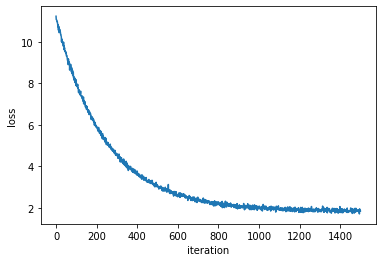

In [31]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy

In [32]:
pred_softmax = softmax_classifier.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
pred_softmax = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

The training accuracy is given by : 40.014286
The validation accuracy is given by : 41.000000


### Testing Softmax

Finally, evaluate the testing accuracy.

In [33]:
pred_softmax = softmax_classifier.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_softmax, y_test)))

The testing accuracy is given by : 39.500000


### Visualization
Visualize the weights of your best model. 

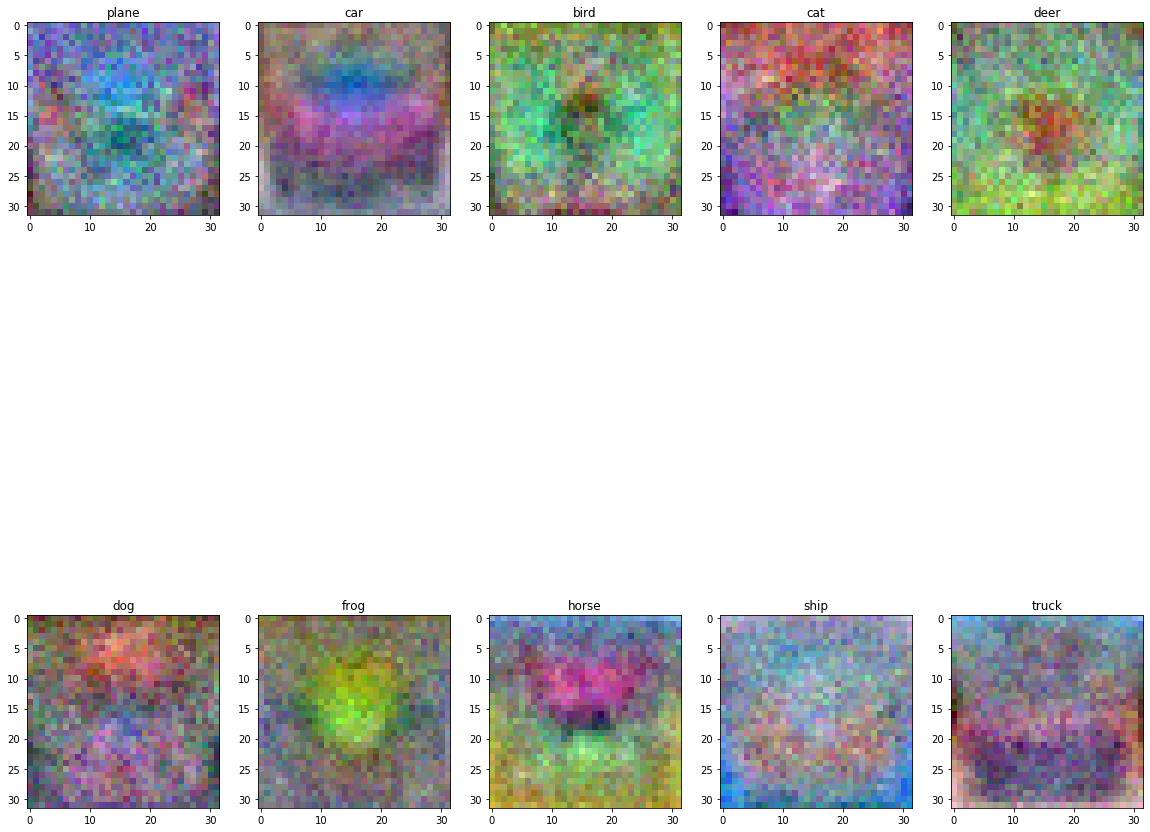

In [34]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (no bias) to (32, 32, 3, 10), and then rescale them back to 0-255 using min-max normalization.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

from sklearn.preprocessing import minmax_scale

# Process weights
temp = softmax_classifier.w[:-1]
temp = minmax_scale(temp, (0,1))
temp = temp.reshape((32,32,3,10))
temp *= 255
temp = temp.astype(int)


fig = plt.figure(figsize=(20,20))    

# Plot for each class
for i,c in enumerate(classes):
    ax = fig.add_subplot(2,5,i+1)
    imgplot = plt.imshow(temp[:,:,:,i])
    ax.set_title(c)

Describe what your visualized weights look like compared to SVM weights.

Your comments: We can see the images are more clearer in softmax as compared to SVM. We can say that softmax weights represents the input image more than the SVM weights. The reason for this could be that the softmax does not use margin to seperate it further.

# Section 3. Multilayer Perceptron (MLP)
In this section, we present you a modified version of simple neural network from Professor Vicente Ordonez at the University of Virginia. You job is to read through the implementation (optional, but highly recommended), and try the MLP classifier. For additional resources on understanding forward and backpropagation, you can check the materials here: http://cs231n.github.io/optimization-2/

Consider a single-layer supervised neural network that has 4 inputs and 3 outputs. First, let's review the skeleton of a single linear layer neural network. The inputs of the network are the variables $x_1, x_2, x_3, x_4$, or the input vector $\mathbf{x}=[x_1, x_2, x_3, x_4]$, the outputs of the network are $\widehat{y}_1,\widehat{y}_2,\widehat{y}_3$, or the output vector $\widehat{\mathbf{y}}=[$$\widehat{y}$$_1,\widehat{y}_2,\widehat{y}_3]$:

<img src="fig/1_layer_fig.png" width="450"/>

The given $j$-th output $\widehat{y}_j$ of this single linear layer + activation function is computed as follows:

$$\widehat{y}_j= \text{sigmoid}(w_{1j}x_1 + w_{2j}x_2 + w_{3j}x_3 + w_{4j}x_4 + b_j) = \text{sigmoid}\Big(\sum_{i=1}^{i=4}w_{ij}x_{i} + b_j\Big)$$

In matrix notation, this would be: 

\begin{equation}
\begin{bmatrix}
  \widehat{y}_{1} \\ 
  \widehat{y}_{2} \\
  \widehat{y}_{3} 
\end{bmatrix}^T=\mathbf{Sigmoid}\Bigg(
\begin{bmatrix}
  x_{1} \\
  x_{2} \\
  x_{3} \\
  x_{4}
\end{bmatrix}^T
\begin{bmatrix}
  w_{1,1} & w_{1,2} & w_{1,3}\\
  w_{2,1} & w_{3,2} & w_{2,3}\\
  w_{3,1} & w_{3,2} & w_{3,3}\\
  w_{4,1} & w_{4,2} & w_{4,3}
\end{bmatrix}
+
\begin{bmatrix}
  b_{1} \\
  b_{2} \\
  b_{3}
\end{bmatrix}^T\Bigg)
\end{equation}

or more compactly:

\begin{equation}
\widehat{\mathbf{y}}^T = \mathbf{Sigmoid}(\mathbf{x}^T \cdot \mathbf{W} + \mathbf{b}^T)
\end{equation}

The element-wise sigmoid function is: $\mathbf{Sigmoid}(\mathbf{x}) = 1 \;/\; (1 + exp(-\mathbf{x}))$, or alternatively: $\mathbf{Sigmoid}(\mathbf{x}) = exp(\mathbf{x})\;/\;(1 + exp(\mathbf{x}))$. Here the sigmoid is separated logically into an activation layer $\sigma(x)$ and a linear layer $\text{linear}(3,4)$ as illustrated in figure. 

Training these weights $\mathbf{W}$ and biases $\mathbf{b}$ requires having many training pairs $(\widehat{\mathbf{y}}^{(m)}, \mathbf{x}^{(m)})$. The inputs $\mathbf{x}$ can be the pixels of an image, indices of words, the entries in a database, and the outputs $\widehat{\mathbf{y}}$ can also be literally anything, including a number indicating a category, a set of numbers indicating the indices of words composing a sentence, an output image itself, etc.

## 3.1. Forward-propagation

Computing the outputs $\widehat{\mathbf{y}}$ from the inputs $\mathbf{x}$ in this network composed of a single linear layer, and a sigmoid layer, is called forward-propagation. Below is the code that implements these two operations:

In [35]:
import numpy as np
import numpy.matlib

class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        
    # y = Wx + b
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def getParameters(self):
        return [self.weight, self.bias]

# Let's test the composition of the two functions (forward-propagation in the neural network).
x1 = np.array([[1, 2, 2, 3]])
y_hat1 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x1))
print('x[1] = '+ str(x1))
print('y_hat[1] = ' + str(y_hat1) + '\n')

# Let's test the composition of the two functions (forward-propagation in the neural network).
x2 = np.array([[4, 5, 2, 1]])
y_hat2 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x2))
print('x[2] = '+ str(x2))
print('y_hat[2] = ' + str(y_hat2) + '\n')

# We can also compute both at once, which could be more efficient since it requires a single matrix multiplication.
x = np.concatenate((x1, x2), axis = 0)
y_hat = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x))
print('x = ' + str(x))
print('y_hat = ' + str(y_hat))

x[1] = [[1 2 2 3]]
y_hat[1] = [[0.49974752 0.49648407 0.50061439]]

x[2] = [[4 5 2 1]]
y_hat[2] = [[0.49635771 0.49935842 0.50401895]]

x = [[1 2 2 3]
 [4 5 2 1]]
y_hat = [[0.49945482 0.50031171 0.50015604]
 [0.49994319 0.49968286 0.49889018]]


## 3.2. Loss functions.

After computing the output predictions $\widehat{\mathbf{y}}$ it is necessary to compare these against the true values of $\mathbf{y}$. Let's call these true, correct, or desired values $\mathbf{y}$. Typically, a simple loss or cost function is used to measure the degree by which the prediction $\widehat{\mathbf{y}}$ is wrong with respect to $\mathbf{y}$. A common loss function for regression is the sum of squared differences between the prediction and its true value. Assuming a prediction $\widehat{\mathbf{y}}^{(d)}$ for our training sample $\mathbf{x}^{(d)}$ with true value $\mathbf{y}^{(d)}$, then the loss can be computed as:

$$loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)}) = (\widehat{y}^{(d)}_1 - y^{(d)}_1)^2 + (\widehat{y}^{(d)}_2 - y^{(d)}_2)^2 + (\widehat{y}^{(d)}_3 - y^{(d)}_3)^2 = \sum_{j=1}^{j=3}(\widehat{y}^{(d)}_j - y^{(d)}_j)^2$$

The goal is to modify the parameters [$\mathbf{W}, \mathbf{b}$] in the Linear layer so that the value of $loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$ becomes as small as possible for all training samples in a set $D=\{(\mathbf{x}^{(d)},\mathbf{y}^{(d)})\}$. This would in turn ensure that predictions $\widehat{\mathbf{y}}$ are as similar as possible to the true values $\mathbf{y}$. To achieve this we need to minimize the following function:

$$\mathcal{L}(\mathbf{W}, \mathbf{b}) = \sum_{d=1}^{d=|D|} loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$$

The only two variables for our model in the function $\mathcal{L}(\mathbf{W}, \mathbf{b})$ are $\mathbf{W}$ and $\mathbf{b}$, this is because the training dataset $D$ is fixed. Finding the values of $\mathbf{W}$ and $\mathbf{b}$ that minimize the the loss, particularly for complex functions, is typically done using gradient based optimization, like Stochastic Gradient Descent (SGD). 

In [36]:
class nn_MSECriterion:  # MSE = mean squared error.
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))

# Let's test the loss function.
y_hat = np.array([[0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33]])
y_true = np.array([[0.25, 0.25, 0.25], [0.33, 0.33, 0.33], [0.77, 0.77, 0.77], [0.80, 0.80, 0.80]])

nn_MSECriterion().forward(y_hat, y_true)

1.6271000000000002

## 3.3. Backward-propagation (Backpropagation)

As we discussed in class, backpropagation is just applying the chain-rule in calculus to compute the derivative of a function which is the composition of many functions (this is essentially definition of the neural network). 

Below is the implementation of required derivative computations for our simple network. You are highly advised to derive the derivatives implemented here to make sure you understand how one arrives at them. 

In [37]:
# This is referred above as f(u).

class nn_MSECriterion:
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))
        
    def backward(self, predictions, labels):
        num_samples = labels.shape[0]
        return 2 * (predictions - labels)
    
# This is referred above as g(v).
class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, x, gradOutput):
        # It is usually a good idea to use gv from the forward pass and not recompute it again here.
        gv = 1 / (1 + np.exp(-x))
        return np.multiply(np.multiply(gv, (1 - gv)), gradOutput)

# This is referred above as h(W, b)
class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.01
        self.bias = np.matlib.randn((1, output_dim)) * 0.01
        self.gradWeight = np.zeros_like(self.weight)
        self.gradBias = np.zeros_like(self.bias)
        
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x, gradOutput):
        # dL/dw = dh/dw * dL/dv
        self.gradWeight = np.dot(x.T, gradOutput)
        # dL/db = dh/db * dL/dv
        #self.gradBias = np.copy(gradOutput)
        self.gradBias = np.copy(np.sum(gradOutput, axis=0))
        # return dL/dx = dh/dx * dL/dv
        return np.dot(gradOutput, self.weight.T)
    
    def getParameters(self):
        params = [self.weight, self.bias]
        gradParams = [self.gradWeight, self.gradBias]
        return params, gradParams
    
# Let's test some dummy inputs for a full pass of forward and backward propagation.
x1 = np.array([[1, 2, 2, 3]])
y1 = np.array([[0.25, 0.25, 0.25]])

# Define the operations.
linear = nn_Linear(4, 3)  # h(W, b)
sigmoid = nn_Sigmoid()  # g(v)
loss = nn_MSECriterion()  # f(u)

# Forward-propagation.
lin = linear.forward(x1)
y_hat = sigmoid.forward(lin)
loss_val = loss.forward(y_hat, y1) # Loss function.

# Backward-propagation.
dy_hat = loss.backward(y_hat, y1)
dlin = sigmoid.backward(lin, dy_hat)
dx1 = linear.backward(x1, dlin)

print('\n num_samples = ' + str(y1.shape[0]))

# Show parameters of the linear layer.
print('\nW = ' + str(linear.weight))
print('B = ' + str(linear.bias))

# Show the intermediate outputs in the forward pass.
print('\nx1    = '+ str(x1))
print('lin   = ' + str(lin))
print('y_hat = ' + str(y_hat))

print('\nloss = ' + str(loss_val))

# Show the intermediate gradients with respect to inputs in the backward pass.
print('\ndy_hat = ' + str(dy_hat))
print('dlin   = ' + str(dlin))
print('dx1    = ' + str(dx1))

# Show the gradients with respect to parameters.
print('\ndW = ' + str(linear.gradWeight))
print('dB = ' + str(linear.gradBias))


 num_samples = 1

W = [[-0.00758602  0.00198164 -0.01211927]
 [-0.01393372  0.00829093  0.01442196]
 [-0.00612525 -0.00333953 -0.00470591]
 [-0.00876524 -0.00434731  0.00231622]]
B = [[-0.02267339 -0.01318006  0.0141483 ]]

x1    = [[1 2 2 3]]
lin   = [[-0.09667305 -0.01433754  0.02840979]]
y_hat = [[0.47585054 0.49641568 0.50710197]]

loss = 0.177830575211527

dy_hat = [[0.45170108 0.49283135 0.51420394]]
dlin   = [[0.11266184 0.12320151 0.12852505]]
dx1    = [[-0.00216814  0.00130524 -0.00170634 -0.00122541]]

dW = [[0.11266184 0.12320151 0.12852505]
 [0.22532368 0.24640301 0.2570501 ]
 [0.22532368 0.24640301 0.2570501 ]
 [0.33798552 0.36960452 0.38557515]]
dB = [[0.11266184 0.12320151 0.12852505]]


## 3.4. Gradient checking 

The gradients can also be computed with numerical approximation using the definition of derivatives. Let a single input pair $(\mathbf{x}, \mathbf{y})$ be the input, for each entry $w_{ij}$ in the weight matrix $\mathbf{W}$, the partial derivatives can be computed as follows:

$$\frac{\partial \mathcal{L}(\mathbf{W},\mathbf{b})}{\partial w_{ij}} = \frac{\mathcal{L}(\mathbf{W} + \mathbf{E}_{ij},b) - \mathcal{L}(\mathbf{W} - \mathbf{E}_{ij}, b)}{2\epsilon}, $$

where $\mathbf{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeros everywhere else. Intuitively this gradient tells how would the value of the loss changes if we change a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Below is the code that checks for a given input $(\mathbf{x}, \mathbf{y})$, the gradients for the matrix $\mathbf{W}$. 

In [38]:
# We will compute derivatives with respect to a single data pair (x,y)
x = np.array([[2.34, 3.8, 34.44, 5.33]])
y = np.array([[3.2, 4.2, 5.3]])

# Define the operations.
linear = nn_Linear(4, 3)
sigmoid = nn_Sigmoid()
criterion = nn_MSECriterion()

# Forward-propagation.
a0 = linear.forward(x)
a1 = sigmoid.forward(a0)
loss = criterion.forward(a1, y) # Loss function.

# Backward-propagation.
da1 = criterion.backward(a1, y)
da0 = sigmoid.backward(a0, da1)
dx = linear.backward(x, da0)

gradWeight = linear.gradWeight
gradBias = linear.gradBias

approxGradWeight = np.zeros_like(linear.weight)
approxGradBias = np.zeros_like(linear.bias)

# We will verify here that gradWeights are correct and leave it as an excercise
# to verify the gradBias.
epsilon = 0.0001
for i in range(0, linear.weight.shape[0]):
    for j in range(0, linear.weight.shape[1]):
        # Compute f(w)
        fw = criterion.forward(sigmoid.forward(linear.forward(x)), y) # Loss function.
        # Compute f(w + eps)
        shifted_weight = np.copy(linear.weight)
        shifted_weight[i, j] = shifted_weight[i, j] + epsilon
        shifted_linear = nn_Linear(4, 3)
        shifted_linear.bias = linear.bias
        shifted_linear.weight = shifted_weight
        fw_epsilon = criterion.forward(sigmoid.forward(shifted_linear.forward(x)), y) # Loss function
        # Compute (f(w + eps) - f(w)) / eps
        approxGradWeight[i, j] = (fw_epsilon - fw) / epsilon

# These two outputs should be similar up to some precision.
print('gradWeight: ' + str(gradWeight))
print('\napproxGradWeight: ' + str(approxGradWeight))

gradWeight: [[ -3.18563579  -4.08568687  -5.47182401]
 [ -5.1732547   -6.63487611  -8.88586806]
 [-46.88602419 -60.13292977 -80.53402524]
 [ -7.25617041  -9.30628675 -12.46359914]]

approxGradWeight: [[ -3.18563587  -4.08556851  -5.47171587]
 [ -5.17325489  -6.63456396  -8.88558281]
 [-46.8859971  -60.10724621 -80.51052981]
 [ -7.25617072  -9.30567259 -12.46303789]]


## Section 3.4. Playing with the Simple NN [30 pts]
Now, we provide a simple NN model that has an training accuracy around 46%. You job here is to first run and check the simple NN model, and the experiments it with:
- Try using 3 different numbers of layers for the simple NN, and plot the accuracy as a function of the number of layers. 
- Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried.
- Try different activation function (Sigmoid, ReLU)
- Briefly describe what you've observed in the above experiments

Note that you are free to create your own Simple_NN class for your experiments.

In [39]:
class nn_CECriterionWithLogits:
    def forward(self, logits, labels):
        y_indices = np.arange(len(labels))
        self.probs = softmax(logits)
        correct_class_prob = self.probs[y_indices, labels].reshape(-1, 1)
        loss = np.sum(-np.log(correct_class_prob)) / len(correct_class_prob)
        return loss
    
    def backward(self, labels):
        y_indices = np.arange(len(labels))
        gradOutput = self.probs
        gradOutput[y_indices, labels] -= 1
        return gradOutput / len(labels)
    
class nn_ReLU:
    def forward(self, x):
        # Forward pass.
        return np.maximum(0, x)
    
    def backward(self, x, gradOutput):
        # Backward pass
        # return np.where(x < 0, 0, np.multiply(x, gradOutput))
        return np.where(x < 0, 0, np.multiply(1, gradOutput))
    
def softmax(x):
    exp = np.exp(x - x.max()) # stability trick
    return (exp / np.sum(exp, axis=1))

In [40]:
class Simple_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

As the bias is explicitly handled in the MLP code, stripped off the ones we have concatenated to the feature vectors.

In [41]:
X_train = X_train[:, :3072]
X_val = X_val[:, :3072]
X_test = X_test[:, :3072]

Now, run the simple NN to check the accuracy:

In [42]:
model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4)

Iter 100/1500 - loss: 2.270370453901699 
Iter 200/1500 - loss: 1.9535180208236513 
Iter 300/1500 - loss: 2.01096628081609 
Iter 400/1500 - loss: 1.8109254851818894 
Iter 500/1500 - loss: 1.910284049882228 
Iter 600/1500 - loss: 1.760245511059203 
Iter 700/1500 - loss: 1.855699057217181 
Iter 800/1500 - loss: 1.6960211198305455 
Iter 900/1500 - loss: 1.8442680370832054 
Iter 1000/1500 - loss: 1.7814104237180708 
Iter 1100/1500 - loss: 1.670622098722558 
Iter 1200/1500 - loss: 1.8471935292674089 
Iter 1300/1500 - loss: 1.7224900001721377 
Iter 1400/1500 - loss: 1.842855017982982 
Iter 1500/1500 - loss: 1.7690955168746538 


The training accuracy is given by : 39.428571
The training accuracy is given by : 38.700000


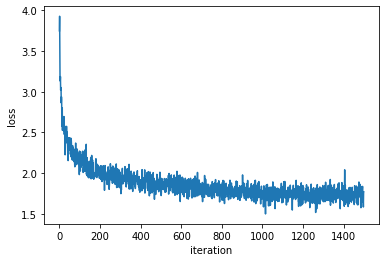

In [43]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))

#### PLEASE NOTE that I have changed the weight initialization in nn_Linear by multiplication factor of 0.01 instead of 0.001

### Section 3.4.1. Different numbers of layers [12 pts]
Try building 3 simple NN with different numbers of layers. Plot the training/validation/test accuracy as a function of the numbers of layers.

#### 3.4.1.1 Simple NN with 2 Hidden Layers

In [44]:
class Simple_NN_2L(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, hidden_state_size)
        self.linear3 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        self.x2 = self.linear2.forward(self.a1)
        self.a2 = self.activation.forward(self.x2)
        logits = self.linear3.forward(self.a2)
        return logits
    
    def backward(self, gradOutput):
        dx3 = self.linear3.backward(self.a2, gradOutput)
        da2 = self.activation.backward(self.x2, dx3)
        dx2 = self.linear2.backward(self.a1, da2)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
        self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)
                                 
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [45]:
training_accuracies = []
validation_accuracies = []
testing_accuracies = []

In [46]:
model_2L = Simple_NN_2L(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 2000
batch_size = 500
loss_hist = model_2L.train(X_train, y_train, lr=1e-4, n_iter=n_iter, batch_size=batch_size)

Iter 100/2000 - loss: 2.2925752413816554 
Iter 200/2000 - loss: 2.2897844119576622 
Iter 300/2000 - loss: 2.2740822002966126 
Iter 400/2000 - loss: 2.261282242073059 
Iter 500/2000 - loss: 2.2571888002226848 
Iter 600/2000 - loss: 2.241640026850352 
Iter 700/2000 - loss: 2.2347425802530765 
Iter 800/2000 - loss: 2.219329430233149 
Iter 900/2000 - loss: 2.1990446991528745 
Iter 1000/2000 - loss: 2.2033135443508827 
Iter 1100/2000 - loss: 2.183511631557054 
Iter 1200/2000 - loss: 2.131446586986185 
Iter 1300/2000 - loss: 2.1563982858062847 
Iter 1400/2000 - loss: 2.1080688780001475 
Iter 1500/2000 - loss: 2.1002435331719607 
Iter 1600/2000 - loss: 2.1000318656729497 
Iter 1700/2000 - loss: 2.0495042275912767 
Iter 1800/2000 - loss: 2.0288679679641906 
Iter 1900/2000 - loss: 2.0280380788749004 
Iter 2000/2000 - loss: 2.039868715594759 


The training accuracy is given by : 27.797959
The validation accuracy is given by : 29.000000
The testing accuracy is given by : 28.500000


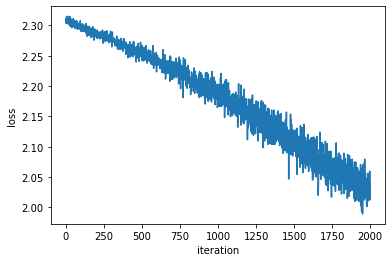

In [47]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model_2L.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
training_accuracies.append(get_acc(predict, y_train))
predict = model_2L.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(predict, y_val)))
validation_accuracies.append(get_acc(predict, y_val))
predict = model_2L.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(predict, y_test)))
testing_accuracies.append(get_acc(predict, y_test))

#### 3.4.1.2 SImple NN with 3 Hidden Layers

In [48]:
class Simple_NN_3L(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, hidden_state_size)
        self.linear3 = nn_Linear(hidden_state_size, hidden_state_size)
        self.linear4 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        self.x2 = self.linear2.forward(self.a1)
        self.a2 = self.activation.forward(self.x2)
        self.x3 = self.linear3.forward(self.a2)
        self.a3 = self.activation.forward(self.x3)
        logits = self.linear4.forward(self.a3)
        return logits
    
    def backward(self, gradOutput):
        dx4 = self.linear4.backward(self.a3, gradOutput)
        da3 = self.activation.backward(self.x3, dx4)
        dx3 = self.linear3.backward(self.a2, da3)
        da2 = self.activation.backward(self.x2, dx3)
        dx2 = self.linear2.backward(self.a1, da2)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
        self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)
        self.linear4.weight = self.linear4.weight - lr * (self.linear4.gradWeight)
        self.linear4.bias = self.linear4.bias - lr * (self.linear4.gradBias)
                                 
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [49]:
model_3L = Simple_NN_3L(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 2000
batch_size = 500
loss_hist = model_3L.train(X_train, y_train, lr=1e-4, n_iter=n_iter, batch_size=batch_size)

Iter 100/2000 - loss: 2.3030194504214236 
Iter 200/2000 - loss: 2.3034926874251562 
Iter 300/2000 - loss: 2.303355864752424 
Iter 400/2000 - loss: 2.3030354081539626 
Iter 500/2000 - loss: 2.3031700862128592 
Iter 600/2000 - loss: 2.3027342122749475 
Iter 700/2000 - loss: 2.302730714897326 
Iter 800/2000 - loss: 2.303050747785263 
Iter 900/2000 - loss: 2.3029307201165286 
Iter 1000/2000 - loss: 2.303225551649173 
Iter 1100/2000 - loss: 2.3031191005282015 
Iter 1200/2000 - loss: 2.3028260360444492 
Iter 1300/2000 - loss: 2.302811722892927 
Iter 1400/2000 - loss: 2.3020379339413193 
Iter 1500/2000 - loss: 2.3031618449757714 
Iter 1600/2000 - loss: 2.302314149950992 
Iter 1700/2000 - loss: 2.302282354882181 
Iter 1800/2000 - loss: 2.303044700129668 
Iter 1900/2000 - loss: 2.302223361250244 
Iter 2000/2000 - loss: 2.3028761881528945 


The training accuracy is given by : 10.720408
The validation accuracy is given by : 8.100000
The testing accuracy is given by : 10.100000


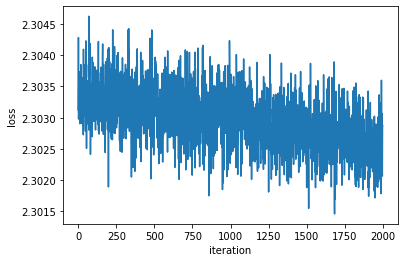

In [50]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model_3L.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
training_accuracies.append(get_acc(predict, y_train))
predict = model_3L.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(predict, y_val)))
validation_accuracies.append(get_acc(predict, y_val))
predict = model_3L.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(predict, y_test)))
testing_accuracies.append(get_acc(predict, y_test))

#### 3.4.1.2 SImple NN with 4 Hidden Layers

In [51]:
class Simple_NN_4L(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, hidden_state_size)
        self.linear3 = nn_Linear(hidden_state_size, hidden_state_size)
        self.linear4 = nn_Linear(hidden_state_size, hidden_state_size)
        self.linear5 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        self.x2 = self.linear2.forward(self.a1)
        self.a2 = self.activation.forward(self.x2)
        self.x3 = self.linear3.forward(self.a2)
        self.a3 = self.activation.forward(self.x3)
        self.x4 = self.linear4.forward(self.a3)
        self.a4 = self.activation.forward(self.x4)
        logits = self.linear5.forward(self.a4)
        return logits
    
    def backward(self, gradOutput):
        dx5 = self.linear5.backward(self.a4, gradOutput)
        da4 = self.activation.backward(self.x4, dx5)
        dx4 = self.linear4.backward(self.a3, da4)
        da3 = self.activation.backward(self.x3, dx4)
        dx3 = self.linear3.backward(self.a2, da3)
        da2 = self.activation.backward(self.x2, dx3)
        dx2 = self.linear2.backward(self.a1, da2)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
        self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)
        self.linear4.weight = self.linear4.weight - lr * (self.linear4.gradWeight)
        self.linear4.bias = self.linear4.bias - lr * (self.linear4.gradBias)
        self.linear5.weight = self.linear5.weight - lr * (self.linear5.gradWeight)
        self.linear5.bias = self.linear5.bias - lr * (self.linear5.gradBias)
                                 
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [52]:
model_4L = Simple_NN_4L(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 2000
batch_size = 500
loss_hist = model_4L.train(X_train, y_train, lr=1e-8, n_iter=n_iter, batch_size=batch_size)

Iter 100/2000 - loss: 2.302304111287458 
Iter 200/2000 - loss: 2.302345201041969 
Iter 300/2000 - loss: 2.3023540500041437 
Iter 400/2000 - loss: 2.302102180818875 
Iter 500/2000 - loss: 2.3024769290383884 
Iter 600/2000 - loss: 2.3032492127397473 
Iter 700/2000 - loss: 2.302767897982162 
Iter 800/2000 - loss: 2.3023009796158114 
Iter 900/2000 - loss: 2.3034079121696913 
Iter 1000/2000 - loss: 2.302381269223377 
Iter 1100/2000 - loss: 2.3021501603736185 
Iter 1200/2000 - loss: 2.3020925164921193 
Iter 1300/2000 - loss: 2.302527436505368 
Iter 1400/2000 - loss: 2.3030019858264548 
Iter 1500/2000 - loss: 2.302716949665613 
Iter 1600/2000 - loss: 2.302836553786626 
Iter 1700/2000 - loss: 2.3025676809183504 
Iter 1800/2000 - loss: 2.302074922483286 
Iter 1900/2000 - loss: 2.3024263532910623 
Iter 2000/2000 - loss: 2.302879517179954 


The training accuracy is given by : 9.989796
The validation accuracy is given by : 10.500000
The testing accuracy is given by : 10.900000


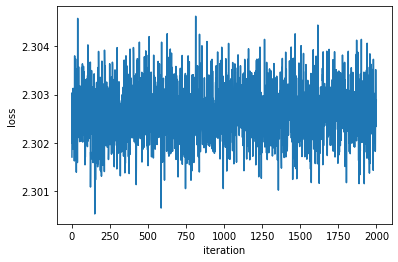

In [53]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model_4L.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
training_accuracies.append(get_acc(predict, y_train))
predict = model_4L.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(predict, y_val)))
validation_accuracies.append(get_acc(predict, y_val))
predict = model_4L.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(predict, y_test)))
testing_accuracies.append(get_acc(predict, y_test))

Text(0.5, 0, 'Number of hidden layers')

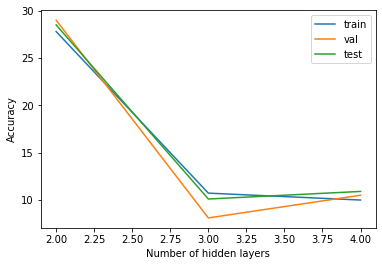

In [54]:
num_hidden_layers = [2,3,4]
plt.plot(num_hidden_layers, training_accuracies, label='train')
plt.plot(num_hidden_layers, validation_accuracies, label='val')
plt.plot(num_hidden_layers, testing_accuracies, label='test')
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend()
plt.xlabel('Number of hidden layers')

### Section 3.4.2. Different numbers of hidden state size [7 pts]
Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried. We recommend you to test numbers like 8, 16, 32, 64, 128, 256. Plot the training/validation/test accuracy as a function of the hidden state size your picked.

In [55]:
hidden_state_sizes = [8, 16, 32, 64, 128, 256]
loss_hists = []
models = []

for hidden_state_size in hidden_state_sizes:
    print("Hidden State size:", hidden_state_size)
    model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=hidden_state_size)
    n_iter = 1500
    batch_size = 200
    loss_hist = model.train(X_train, y_train, lr=1e-4)
    print()
    
    models.append(model)
    loss_hists.append(loss_hist)

Hidden State size: 8
Iter 100/1500 - loss: 2.1761370903802884 
Iter 200/1500 - loss: 2.198412861427154 
Iter 300/1500 - loss: 2.0899881047307387 
Iter 400/1500 - loss: 2.0086440665406173 
Iter 500/1500 - loss: 1.8967713452254702 
Iter 600/1500 - loss: 1.9791327335768836 
Iter 700/1500 - loss: 1.9385893040756548 
Iter 800/1500 - loss: 1.938046813381211 
Iter 900/1500 - loss: 1.948474151774796 
Iter 1000/1500 - loss: 1.9227014264893978 
Iter 1100/1500 - loss: 1.9551014341643325 
Iter 1200/1500 - loss: 1.9319110840889266 
Iter 1300/1500 - loss: 1.8467288433808589 
Iter 1400/1500 - loss: 1.770512430210416 
Iter 1500/1500 - loss: 1.931358848475865 

Hidden State size: 16
Iter 100/1500 - loss: 2.297897789454082 
Iter 200/1500 - loss: 2.0761063223358165 
Iter 300/1500 - loss: 2.008891105094658 
Iter 400/1500 - loss: 1.9845516296229389 
Iter 500/1500 - loss: 1.9657337363798533 
Iter 600/1500 - loss: 1.916796023568869 
Iter 700/1500 - loss: 1.97601415289419 
Iter 800/1500 - loss: 1.990885216804

Hidden State size: 8
The training accuracy is given by : 31.171429
The validation accuracy is given by : 32.500000
The testing accuracy is given by : 31.000000

Hidden State size: 16
The training accuracy is given by : 34.426531
The validation accuracy is given by : 34.700000
The testing accuracy is given by : 36.600000

Hidden State size: 32
The training accuracy is given by : 37.351020
The validation accuracy is given by : 36.800000
The testing accuracy is given by : 39.500000

Hidden State size: 64
The training accuracy is given by : 39.120408
The validation accuracy is given by : 38.700000
The testing accuracy is given by : 38.700000

Hidden State size: 128
The training accuracy is given by : 41.897959
The validation accuracy is given by : 40.500000
The testing accuracy is given by : 41.800000

Hidden State size: 256
The training accuracy is given by : 43.104082
The validation accuracy is given by : 39.800000
The testing accuracy is given by : 39.000000



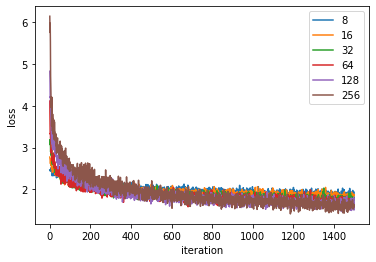

In [56]:
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
for i,(model,loss_hist) in enumerate(zip(models,loss_hists)):
    print("Hidden State size:", 2**(i+3))
    plt.plot(loss_hist, label = str(2**(i+3)))
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.legend()
    predict = model.predict(X_train)
    print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
    training_accuracies.append(get_acc(predict, y_train))
    predict = model.predict(X_val)
    print('The validation accuracy is given by : %f' % (get_acc(predict, y_val)))
    validation_accuracies.append(get_acc(predict, y_val))
    predict = model.predict(X_test)
    print('The testing accuracy is given by : %f' % (get_acc(predict, y_test)))
    testing_accuracies.append(get_acc(predict, y_test))
    print()

Text(0.5, 0, 'hidden state size')

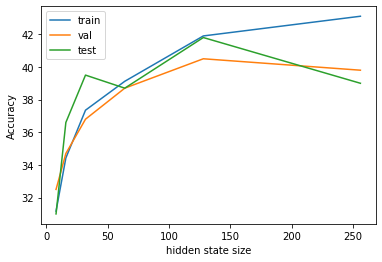

In [57]:
plt.plot(hidden_state_sizes, training_accuracies, label='train')
plt.plot(hidden_state_sizes, validation_accuracies, label='val')
plt.plot(hidden_state_sizes, testing_accuracies, label='test')
plt.ylabel('Accuracy')
plt.legend()
plt.xlabel('hidden state size')

### Section 3.4.3. Different activation functions [7 pts]
Try both ReLU and Sigmoid activation, and report the training/validation/test accuracy.

In [58]:
class Simple_NN_Sigmoid(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_Sigmoid()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [59]:
training_accuracies = []
validation_accuracies = []
testing_accuracies = []

In [60]:
model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4)

Iter 100/1500 - loss: 2.1946675128170843 
Iter 200/1500 - loss: 2.0952399382445552 
Iter 300/1500 - loss: 2.0470469958927673 
Iter 400/1500 - loss: 1.8648974047836568 
Iter 500/1500 - loss: 1.9239312761332281 
Iter 600/1500 - loss: 1.8462634289742939 
Iter 700/1500 - loss: 1.8445862919665101 
Iter 800/1500 - loss: 1.817450430237705 
Iter 900/1500 - loss: 1.7596123016203853 
Iter 1000/1500 - loss: 1.8008698923837085 
Iter 1100/1500 - loss: 1.8378033958001898 
Iter 1200/1500 - loss: 1.6786102493927784 
Iter 1300/1500 - loss: 1.8153957877630933 
Iter 1400/1500 - loss: 1.8652385395757927 
Iter 1500/1500 - loss: 1.7956642274405958 


The training accuracy is given by : 39.169388
The validation accuracy is given by : 39.900000
The testing accuracy is given by : 37.900000


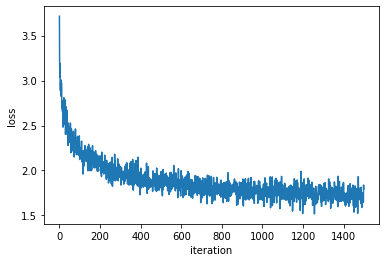

In [61]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
training_accuracies.append(get_acc(predict, y_train))
predict = model.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(predict, y_val)))
validation_accuracies.append(get_acc(predict, y_val))
predict = model.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(predict, y_test)))
testing_accuracies.append(get_acc(predict, y_test))

In [62]:
model_sigmoid = Simple_NN_Sigmoid(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model_sigmoid.train(X_train, y_train, lr=1e-4)

Iter 100/1500 - loss: 2.305354729709684 
Iter 200/1500 - loss: 2.3073572216115377 
Iter 300/1500 - loss: 2.310175113125533 
Iter 400/1500 - loss: 2.293872479107747 
Iter 500/1500 - loss: 2.295959535408294 
Iter 600/1500 - loss: 2.2921604412698433 
Iter 700/1500 - loss: 2.2995822474610876 
Iter 800/1500 - loss: 2.294378063053972 
Iter 900/1500 - loss: 2.2967054027345593 
Iter 1000/1500 - loss: 2.2945139941681405 
Iter 1100/1500 - loss: 2.2920331643258645 
Iter 1200/1500 - loss: 2.2882586725504086 
Iter 1300/1500 - loss: 2.288818943993816 
Iter 1400/1500 - loss: 2.2813732418898693 
Iter 1500/1500 - loss: 2.2882175498540698 


The training accuracy is given by : 14.363265
The validation accuracy is given by : 12.900000
The testing accuracy is given by : 10.900000


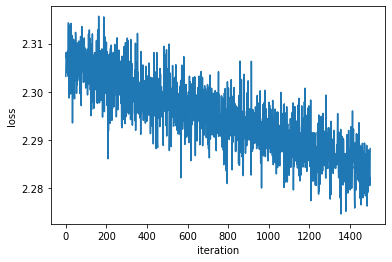

In [63]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model_sigmoid.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
training_accuracies.append(get_acc(predict, y_train))
predict = model_sigmoid.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(predict, y_val)))
validation_accuracies.append(get_acc(predict, y_val))
predict = model_sigmoid.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(predict, y_test)))
testing_accuracies.append(get_acc(predict, y_test))

### Section 3.4.4. What did you see? [4 pts]
Desribe what you see in the experiments above in 5-6 sentences.

#### Your answer:   
##### In 3.4.1, 
We can see that as we increase the layers, learning is becoming tough. One possible reason for this could be that as the hidden layers increase the complexity of model increases and training the model become more difficult.  

##### In 3.4.2, 
We can see that the accuracy increases with the increase in hidden state size of the model. If we see the loss plots of the models with different hidden state sizes, we can deduce that the loss for model with higher hidden state size is converging faster and better. But the testing accuracy is not increasing after hidden state size 64. So maybe the model overfits after increasing the hidden state size over 128.   

##### In 3.4.3, 
We can see from the loss plots that that the learning is faster with ReLU than with Sigmoid activation function. Therefore the accuracy after 1500 iterations is more with ReLU.  
So for 1500 iterations, we can say that ReLU is performing better than Sigmoid Activation function.  
But, from this, we cannot conclude that the ReLU activation is better than Sigmoid, because from the loss plot we can see that Sigmoid model's loss is still converging, and it may overtake the model with ReLU activation with more number of iterations like 3000, 4000.

<!-- 
From results of 3.4.1 and 3.4.2 we can say that the increase in hidden state size could be better than the increase in layers. -->